# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

### 31 Pytorch A simple PyTorch Convolutional Nerual Network (CNN) classifier for Numer.Ai Binary Classification problem using CONV1D (one dimentional convolution). 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


### Data
- Download from https://numer.ai/leaderboard

<img src="../images/Numerai.png" width="35%" align="center">

# One dimetional CNN? Convolutional Nerual Network (CNN) using one dimentional convolution (CONV1D).

- Indeed, most of the existing PyTorch examples are using Images, while here we have a CSV with 21 features. Using CONV1D *before or after a Lineer layer* requires the use of **reshaping**, and this is the **whole point of this tutorial**. 

- Thus, the CNN architecture is naive and by no means **optimized**. Hopefully, I will improve it over time and I am working on a second CNN based version of the same problem. 


# Introduction

- This tutorial was written in order to demonstrate a **fully working** example of a PyTorch **CNN** on a real world use case, namely a Binary Classification problem. 

- If you are interested in the sk-learn version of this problem please refer to: https://github.com/QuantScientist/deep-ml-meetups/tree/master/hacking-kaggle/python/numer-ai 

- For the scientific foundation behind Binary Classification and Logistic Regression, refer to: https://github.com/QuantScientist/Deep-Learning-Boot-Camp/tree/master/Data-Science-Interviews-Book

- Every step, from reading the CSV into numpy arrays, converting to GPU based tensors, training and validation, are meant to aid newcomers in their first steps in PyTorch. 

- Additionally, commonly used Kaggle metrics such as ROC_AUC and LOG_LOSS are logged and plotted both for the training set as well as for the validation set. 

# PyTorch Imports


In [33]:
# !pip install pycuda
%reset -f
# %%timeit

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)

handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

# %%timeit
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

lgr.info("USE CUDA=" + str (use_cuda))

tensorflow:1.2.1


INFO:__main__:USE CUDA=False


__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0+42448cf
__CUDA VERSION
__CUDNN VERSION: None
__Number CUDA Devices: 0
__Devices
OS:  linux2
Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
PyTorch:  0.2.0+42448cf
Numpy:  1.13.1
2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
19.3
svmem(total=67469099008, available=45196423168, percent=33.0, used=21583908864, free=31378059264, active=30156333056, inactive=4534312960, buffers=1042288640, cached=13464842240, shared=140500992)
memory GB: 1.34589004517


#  Global params

In [34]:
# NN params
LR = 0.005
MOMENTUM= 0.9

# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)    

#  View the Data
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [35]:
# Data params
TARGET_VAR= 'target'
TOURNAMENT_DATA_CSV = 'numerai_tournament_data.csv'
TRAINING_DATA_CSV = 'numerai_training_data.csv'
BASE_FOLDER = 'numerai/'

df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
df_train.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,135682,era1,train,0.53352,0.64336,0.46577,0.53001,0.55734,0.45773,0.41169,...,0.51224,0.50484,0.41929,0.50954,0.47383,0.48797,0.38373,0.46233,0.33341,0
1,110546,era1,train,0.54196,0.81576,0.46632,0.62320,0.52427,0.64378,0.55662,...,0.52643,0.63809,0.67121,0.49421,0.45291,0.46932,0.54445,0.30997,0.19023,0
2,76047,era1,train,0.49158,0.69131,0.57816,0.54010,0.43064,0.49986,0.61902,...,0.43310,0.72286,0.76257,0.36600,0.55330,0.56566,0.67528,0.34960,0.25721,1
3,66098,era1,train,0.54519,0.42473,0.63472,0.39003,0.37485,0.43810,0.59557,...,0.41658,0.63417,0.50189,0.40883,0.58705,0.63785,0.56225,0.55989,0.58642,0
4,88227,era1,train,0.44307,0.74076,0.52210,0.56543,0.51125,0.66457,0.42263,...,0.45851,0.58805,0.49860,0.48023,0.52606,0.53253,0.38361,0.43829,0.25014,0


#  Train / Validation / Test Split
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
import spectrum

def featureFFT(y):
    fs = 400
    n = len(y)
    dt = 1 / float(fs)  # Get time resolution

    fft_output = np.fft.rfft(y)  # Perform real fft
    rfreqs = np.fft.rfftfreq(n, dt)  # Calculatle frequency bins
    fft_mag = np.abs(fft_output)  # Take only the magnitude of the spectrum
    fft_mag = fft_mag * 2 / n

    return fft_mag

def featureAR(ch):
    ar_coeffs, dnr, reflection_coeffs = spectrum.aryule(ch, order=8)
    return np.abs(ar_coeffs)


def featureEnt( row, base=2):
    x_ent= -((np.log(row) / np.log(base)) * row).sum(axis=0)
    return x_ent


def featureShannonEnt(row):
    row=row.div(row.sum())
    # print (row)
    return -sum([p * math.log(p) for p in row if p != 0])


def enrichFeatures( row):
    # print (len(row))
    x_fft = featureFFT(row)
    x_ent = featureShannonEnt(row)
    x_ar =  featureAR(row)
    s = pd.Series({'x_ent': x_ent, 'ar1': x_ar[0], 'ar2': x_ar[1], 'ar3': x_ar[2], 'ar4': x_ar[3], 'ar5': x_ar[4],
                   'ar6': x_ar[5], 'ar7': x_ar[6], 'ar8': x_ar[7],
                   'x_fft1': x_fft[0], 'x_fft2': x_fft[1], 'x_fft3': x_fft[2], 'x_fft4': x_fft[3],
                   'x_fft5': x_fft[4], 'x_fft6': x_fft[5], 'x_fft7': x_fft[6], 'x_fft8': x_fft[7],
                   'x_fft9': x_fft[8], 'x_fft10': x_fft[9],'x_fft11': x_fft[10]})
    # print (s)
    return s

def genBasicFeatures(inDF):
    print('Generating basic features ...')
    df_copy=inDF.copy(deep=True)
    magicNumber=21
    feature_cols = list(inDF.columns)

#     inDF['x_mean'] = np.mean(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_median'] = np.median(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_std'] = np.std(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_skew'] = scipy.stats.skew(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_kurt'] = scipy.stats.kurtosis(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_var'] = np.var(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_max'] = np.max(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_min'] = np.min(df_copy.ix[:, 0:magicNumber], axis=1)
    # http://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns
    inDF=inDF.merge(df_copy.ix[:, 0:magicNumber].apply(lambda row: enrichFeatures(row), axis=1),
                    left_index=True, right_index=True)
    return inDF

# Train, Validation, Test Split
def loadDataSplit():
    df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    df_test_valid = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)

    answers_1_SINGLE = df_train[TARGET_VAR]
    df_train.drop(TARGET_VAR, axis=1,inplace=True)
    df_train.drop('id', axis=1,inplace=True)
    df_train.drop('era', axis=1,inplace=True)
    df_train.drop('data_type', axis=1,inplace=True)    

#     df_train=genBasicFeatures(df_train)
    
    df_train.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=False,  index = False)    
    df_train= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=None, dtype=np.float32)    
    df_train = pd.concat([df_train, answers_1_SINGLE], axis=1)
    feature_cols = list(df_train.columns[:-1])
    target_col = df_train.columns[-1]
    trainX, trainY = df_train[feature_cols], df_train[target_col]
    
        
    df_validation_set=df_test_valid.loc[df_test_valid['data_type'] == 'validation'] 
    df_validation_set=df_validation_set.copy(deep=True)
    answers_1_SINGLE_validation = df_validation_set[TARGET_VAR]
    df_validation_set.drop(TARGET_VAR, axis=1,inplace=True)    
    df_validation_set.drop('id', axis=1,inplace=True)
    df_validation_set.drop('era', axis=1,inplace=True)
    df_validation_set.drop('data_type', axis=1,inplace=True)
    
#     df_validation_set=genBasicFeatures(df_validation_set)
        
    df_validation_set.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=False,  index = False)    
    df_validation_set= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=None, dtype=np.float32)    
    df_validation_set = pd.concat([df_validation_set, answers_1_SINGLE_validation], axis=1)
    feature_cols = list(df_validation_set.columns[:-1])

    target_col = df_validation_set.columns[-1]
    valX, valY = df_validation_set[feature_cols], df_validation_set[target_col]
                                
    df_test_set = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)
    df_test_set=df_test_set.copy(deep=True)
    df_test_set.drop(TARGET_VAR, axis=1,inplace=True)
    tid_1_SINGLE = df_test_set['id']
    df_test_set.drop('id', axis=1,inplace=True)
    df_test_set.drop('era', axis=1,inplace=True)
    df_test_set.drop('data_type', axis=1,inplace=True)   
    
#     df_test_set=genBasicFeatures(df_test_set) 
    
    feature_cols = list(df_test_set.columns) # must be run here, we dont want the ID    
    df_test_set = pd.concat([tid_1_SINGLE, df_test_set], axis=1)            
    testX = df_test_set[feature_cols].values
        
    return trainX, trainY, valX, valY, testX, df_test_set

In [37]:
trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()

print (trainX.shape)
print (trainY.shape)
print (valX.shape)
print (valY.shape)
print (testX.shape)
print (df_test_set.shape)

(108405, 21)
(108405,)
(16686, 21)
(16686,)
(45647, 21)
(45647, 22)


In [6]:
trainX.head(5) # with new features added

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.53352,0.64336,0.46577,0.53001,0.55734,0.45773,0.41169,0.52070,0.36351,0.72262,...,0.59757,0.51224,0.50484,0.41929,0.50954,0.47383,0.48797,0.38373,0.46233,0.33341
1,0.54196,0.81576,0.46632,0.62320,0.52427,0.64378,0.55662,0.43845,0.12690,0.72814,...,0.65167,0.52643,0.63809,0.67121,0.49421,0.45291,0.46932,0.54445,0.30997,0.19023
2,0.49158,0.69131,0.57816,0.54010,0.43064,0.49986,0.61902,0.44719,0.12617,0.64512,...,0.58387,0.43310,0.72286,0.76257,0.36600,0.55330,0.56566,0.67528,0.34960,0.25721
3,0.54519,0.42473,0.63472,0.39003,0.37485,0.43810,0.59557,0.43393,0.44115,0.41381,...,0.37095,0.41658,0.63417,0.50189,0.40883,0.58705,0.63785,0.56225,0.55989,0.58642
4,0.44307,0.74076,0.52210,0.56543,0.51125,0.66457,0.42263,0.55584,0.30143,0.80876,...,0.57756,0.45851,0.58805,0.49860,0.48023,0.52606,0.53253,0.38361,0.43829,0.25014


In [38]:
# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def XnumpyToTensor(x_data_np):
    x_data_np = np.array(x_data_np.values, dtype=np.float32)        
    print(x_data_np.shape)
    print(type(x_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")    
        X_tensor = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        lgr.info ("Using the CPU")
        X_tensor = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    
    print(type(X_tensor.data)) # should be 'torch.cuda.FloatTensor'            
    print((X_tensor.data.shape)) # torch.Size([108405, 29])
    return X_tensor


# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def YnumpyToTensor(y_data_np):    
    y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!
    print(y_data_np.shape)
    print(type(y_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")            
    #     Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor).cuda()  # BCEloss requires Float        
    else:
        lgr.info ("Using the CPU")        
    #     Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor)  # BCEloss requires Float        

    print(type(Y_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(y_data_np.shape)
    print(type(y_data_np))    
    return Y_tensor

# CNN Architecture


In [39]:
# References:
# https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/5_convolutional_net.py
# https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556

# use_cuda=False
X_tensor_train= XnumpyToTensor(trainX) # default order is NBC for a 3d tensor, but we have a 2d tensor
X_shape=X_tensor_train.data.size()

# Dimensions
# Number of features for the input layer
N_FEATURES=trainX.shape[1]
# Number of rows
NUM_ROWS_TRAINNING=trainX.shape[0]
# this number has no meaning except for being divisable by 2
N_MULT_FACTOR=8 # min should be 4
# Size of first linear layer
N_HIDDEN=N_FEATURES * N_MULT_FACTOR
# CNN kernel size
N_CNN_KERNEL=3
MAX_POOL_KERNEL=4

DEBUG_ON=False

def debug(x):
    if DEBUG_ON:
        print ('(x.size():' + str (x.size()))
    
class Net2(nn.Module):    
    def __init__(self, n_feature, n_hidden, n_output, n_cnn_kernel, n_mult_factor=N_MULT_FACTOR):
        super(Net2, self).__init__()
        self.n_feature=n_feature
        self.n_hidden=n_hidden
        self.n_output= n_output 
        self.n_cnn_kernel=n_cnn_kernel
        self.n_mult_factor=n_mult_factor
        self.n_l2_hidden=self.n_hidden * (self.n_mult_factor - self.n_cnn_kernel + 3)
#         self.n_out_hidden=int (self.n_l2_hidden/2)
                        
        self.l1 = nn.Sequential(
            torch.nn.Linear(self.n_feature, self.n_hidden),
            torch.nn.Dropout(p=1 -.85),            
            torch.nn.LeakyReLU (0.1),            
            torch.nn.BatchNorm1d(self.n_hidden, eps=1e-05, momentum=0.1, affine=True)            
        )                
        self.c1= nn.Sequential(            
            torch.nn.Conv1d(self.n_feature, self.n_hidden, 
                            kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(1,)),
            torch.nn.Dropout(p=1 -.75),            
            torch.nn.LeakyReLU (0.1),
            torch.nn.BatchNorm1d(self.n_hidden, eps=1e-05, momentum=0.1, affine=True)        
        )                        
        self.out = nn.Sequential(
            torch.nn.Linear(self.n_l2_hidden,
                            self.n_output),  
        )                
        self.sig=nn.Sigmoid()

        
    def forward(self, x):
        debug(x)
        varSize=x.data.shape[0] # must be calculated here in forward() since its is a dynamic size        
        x=self.l1(x)                
        debug(x)
        # for CNN        
        x = x.view(varSize,self.n_feature,self.n_mult_factor)
        debug(x)
        x=self.c1(x)
        debug(x)
        # for Linear layer
        x = x.view(varSize, self.n_hidden * (self.n_mult_factor -self.n_cnn_kernel + 3))
        debug(x)
#         x=self.l2(x)                    
        x=self.out(x)   
        debug(x)
        x=self.sig(x)
        return x
    
net = Net2(n_feature=N_FEATURES, n_hidden=N_HIDDEN, n_output=1, n_cnn_kernel=N_CNN_KERNEL)   # define the network    
if use_cuda:
    net=net.cuda() # very important !!!
lgr.info(net)
b = net(X_tensor_train)
print ('(b.size():' + str (b.size())) # torch.Size([108405, 928])

INFO:__main__:Using the CPU
INFO:__main__:Net2 (
  (l1): Sequential (
    (0): Linear (21 -> 168)
    (1): Dropout (p = 0.15)
    (2): LeakyReLU (0.1)
    (3): BatchNorm1d(168, eps=1e-05, momentum=0.1, affine=True)
  )
  (c1): Sequential (
    (0): Conv1d(21, 168, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Dropout (p = 0.25)
    (2): LeakyReLU (0.1)
    (3): BatchNorm1d(168, eps=1e-05, momentum=0.1, affine=True)
  )
  (out): Sequential (
    (0): Linear (1344 -> 1)
  )
  (sig): Sigmoid ()
)


(108405, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([108405, 21])
(b.size():torch.Size([108405, 1])


In [40]:
optimizer = torch.optim.Adam(net.parameters(), lr=LR,weight_decay=5e-4) #  L2 regularization
loss_func=torch.nn.BCELoss() # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
if use_cuda:
    lgr.info ("Using the GPU")    
    net.cuda()
    loss_func.cuda()

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:<torch.optim.adam.Adam object at 0x7f6754dd2110>
INFO:__main__:BCELoss (
)


In [ ]:
import time
start_time = time.time()    
epochs=100
all_losses = []

X_tensor_train= XnumpyToTensor(trainX)
Y_tensor_train= YnumpyToTensor(trainY)

print(type(X_tensor_train.data), type(Y_tensor_train.data)) # should be 'torch.cuda.FloatTensor'

# From here onwards, we must only use PyTorch Tensors
for step in range(epochs):
    out = net(X_tensor_train)                 # input x and predict based on x
    cost = loss_func(out, Y_tensor_train)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
                           
    if step % 10 == 0:        
        loss = cost.data[0]
        all_losses.append(loss)
        print(step, cost.data.cpu().numpy())        
        prediction = (net(X_tensor_train).data).float() # probabilities             
        pred_y = prediction.cpu().numpy().squeeze()
        target_y = Y_tensor_train.cpu().data.numpy()                        
        tu = ((pred_y == target_y).mean(),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        print ('ACC={}, LOG_LOSS={}, ROC_AUC={} '.format(*tu))        
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(108405, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([108405, 21])
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
0 [ 0.70974463]
ACC=0.0, LOG_LOSS=0.77632911927, ROC_AUC=0.496740048481 
10 [ 0.69717395]
ACC=0.0, LOG_LOSS=0.697419923693, ROC_AUC=0.508009778805 
20 [ 0.69489557]
ACC=0.0, LOG_LOSS=0.694790536928, ROC_AUC=0.500532412995 
30 [ 0.69356298]
ACC=0.0, LOG_LOSS=0.693470323289, ROC_AUC=0.509168138512 
40 [ 0.69294286]
ACC=0.0, LOG_LOSS=0.693103163234, ROC_AUC=0.509802476296 
50 [ 0.69272161]
ACC=0.0, LOG_LOSS=0.69260831799, ROC_AUC=0.517115349435 
60 [ 0.69262892]
ACC=0.0, LOG_LOSS=0.692349490455, ROC_AUC=0.520382015719 
70 [ 0.692168]
ACC=0.0, LOG_LOSS=0.692350919956, ROC_AUC=0.521017668476 
80 [ 0.69255126]
ACC=0.0, LOG_LOSS=0.692755391916, ROC_AUC=0.516892704063 
90 [ 0.6922549]
ACC=0.0, LOG_LOSS=0.692267138698, ROC_AUC=0.521785201886 


# Validation ROC_AUC

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(16686, 21)
(16686,)
(16686, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([16686, 21])
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


acc=0.0 log_loss=0.692840326255 roc_auc=0.523071687249 


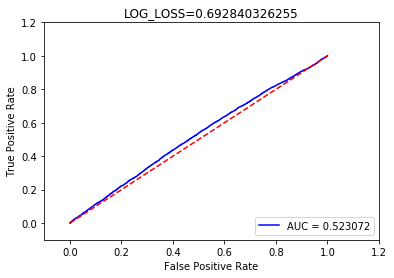

In [45]:
net.eval()
# Validation data
print (valX.shape)
print (valY.shape)

X_tensor_val= XnumpyToTensor(valX)
Y_tensor_val= YnumpyToTensor(valY)


print(type(X_tensor_val.data), type(Y_tensor_val.data)) # should be 'torch.cuda.FloatTensor'

predicted_val = (net(X_tensor_val).data).float() # probabilities 
# predicted_val = (net(X_tensor_val).data > 0.5).float() # zero or one
pred_y = predicted_val.cpu().numpy()
target_y = Y_tensor_val.cpu().data.numpy()                

print (type(pred_y))
print (type(target_y))

tu = (str ((pred_y == target_y).mean()),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('\n')
print ('acc={} log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print (pred_y)

# Submision

In [46]:
print (df_test_set.shape)
columns = ['id', 'probability']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
df_pred.id.astype(int)

for index, row in df_test_set.iterrows():
    rwo_no_id=row.drop('id')    
#     print (rwo_no_id.values)    
    x_data_np = np.array(rwo_no_id.values, dtype=np.float32)        
    if use_cuda:
        X_tensor_test = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        X_tensor_test = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
                    
    X_tensor_test=X_tensor_test.view(1, trainX.shape[1]) # does not work with 1d tensors            
    predicted_val = (net(X_tensor_test).data).float() # probabilities     
    p_test =   predicted_val.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    df_pred = df_pred.append({'id':row['id'].astype(int), 'probability':p_test},ignore_index=True)
    
df_pred.head(5)

(45647, 22)


,id,probability
0,97040.0,0.510508
1,65399.0,0.496846
2,147258.0,0.502671
3,129573.0,0.512110
4,134978.0,0.517421


In [47]:
df_pred.id=df_pred.id.astype(int)

def savePred(df_pred, loss):
#     csv_path = 'pred/p_{}_{}_{}.csv'.format(loss, name, (str(time.time())))
    csv_path = 'pred/pred_{}_{}.csv'.format(loss, (str(time.time())))
    df_pred.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print (csv_path)
    
savePred (df_pred, log_loss(target_y, pred_y))

pred/pred_0.692840326255_1504874705.3.csv
